In [1]:
%load_ext autoreload
%autoreload 2

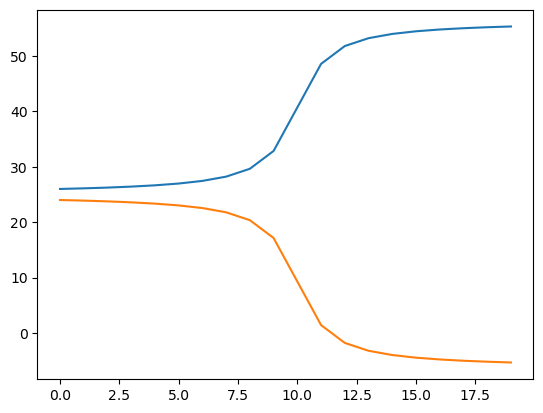

In [12]:
import numpy as np
import matplotlib.pyplot as plt
shape = [20, 2, 50, 50]
img = np.zeros(shape)
p1 = [shape[2]/2, shape[3]/2+10*(np.pi/2+np.arctan(t-shape[0]/2))]
p2 = [shape[2]/2, shape[3]/2-10*(np.pi/2+np.arctan(t-shape[0]/2))]
plt.plot(p1[1])
plt.plot(p2[1])

img[p1]

/media/cephfs2/jparham/Joe for Jerome /SegA Live imaging /20240229_delSegA/CroppedDivisions/01a_delSegA_CM_SyS_reg_Cell_0.tif
Image shape (441, 2, 60, 60) (441, 2, 60, 60)


Text(0.5, 1.0, '01a_delSegA_CM_SyS_reg_Cell_0')

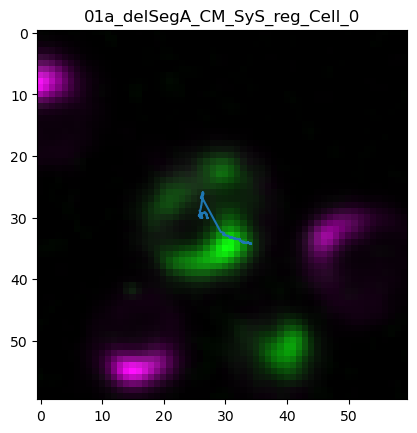

In [52]:
from pathlib import Path
import tifffile
import dnasufo as mq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# list files from the src folder
root = Path('/media/cephfs2/jparham/')
dst = Path('/media/cephfs2/jeromeb/userdata/Baum_group/jparham/Analysis7/')
filelist = pd.read_csv(dst/'filelist.csv')
filelist = filelist.replace(u"\uf028"," ")

# 
index = 0
filename = filelist['path'].iloc[index]
print(filename)
pimg, cell_lbl, cell_trj, cell_flow, dna_lbl, dna_trj, dna_flow = mq.process(filename)
plt.imshow(mq.uv2rgb(pimg[0]))
plt.plot(cell_trj['centroid-1'], cell_trj['centroid-0'])
plt.title(Path(filename).stem)

In [47]:
import napari
v = napari.view_image(pimg,channel_axis=1)
v.add_labels(np.squeeze(cell_lbl))
v.add_labels(np.squeeze(dna_lbl))
v.add_tracks(cell_trj[['label', 'frame','centroid-0','centroid-1']])

<Tracks layer 'Tracks' at 0x763e96a69290>

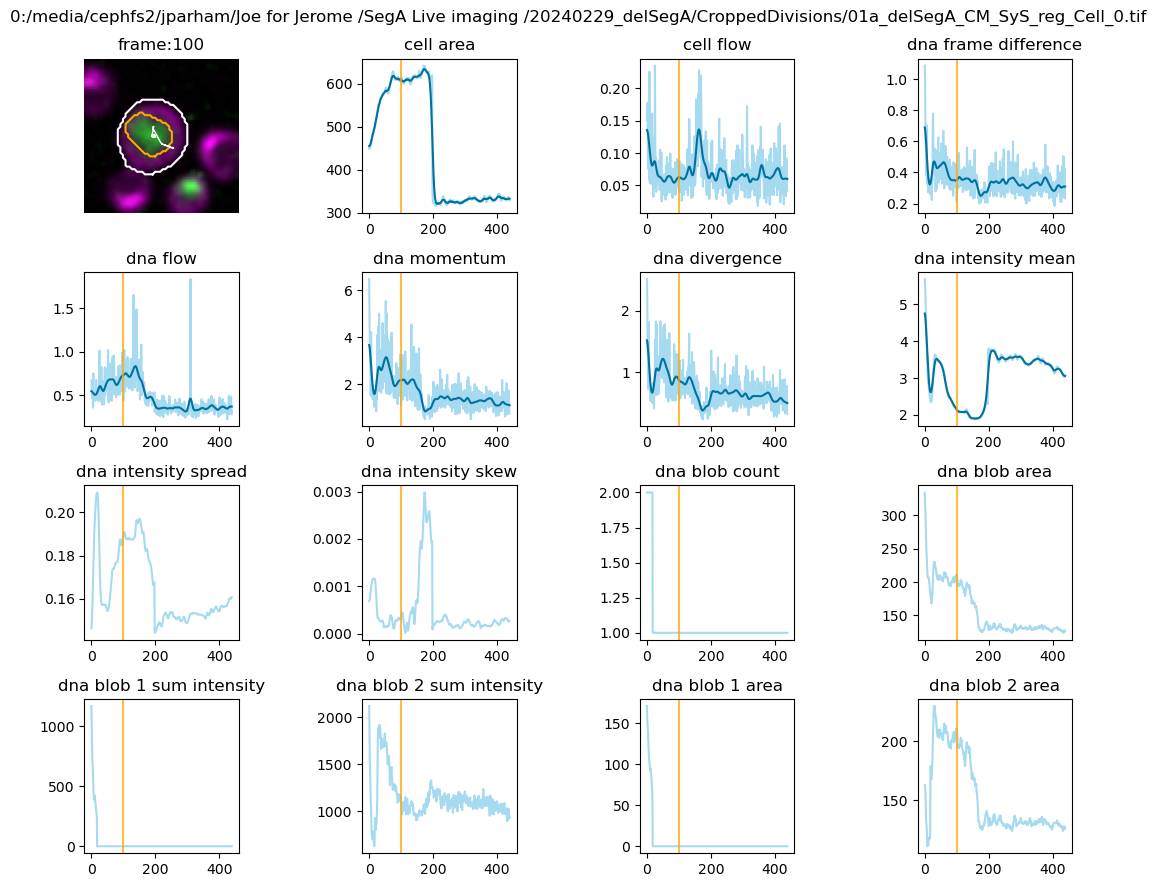

In [51]:
mq.create_figure(index, filename, pimg, cell_lbl, cell_trj, cell_flow, dna_lbl, dna_trj, dna_flow, frame=100)

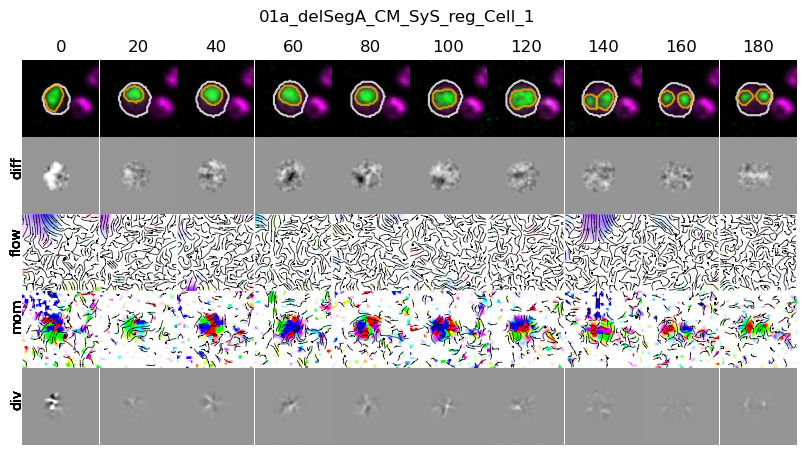

In [36]:
mq.create_strip(filename, pimg, cell_lbl, cell_trj, cell_flow, dna_lbl, dna_trj, dna_flow,selection=slice(0,200,20))

In [40]:
results_path = Path('tmp.h5')
if results_path.exists():
    results_path.unlink()
mq.save_result(results_path, Path(filename).stem, pimg, cell_lbl, cell_trj, cell_flow, dna_lbl, dna_trj, dna_flow)